# Exploratory Analisys

## Context

Given our focus on forecasting temperature one year ahead, we will use only features with at least 365 lags. This ensures that we have sufficient input information to predict 365 steps ahead. Although this notebook was developed after **eda-autoregressive.ipynb**, it can also be executed following **eda-linear.ipynb** without loss of understanding or data continuity. In this notebook, our objective is to forecast all 365 days directly, rather than using the recursive forecasting approach employed in ARIMA models.

**Data Source**
The data used in this notebook was extracted from the notebook *eda-linear.ipynb*

- **Data:** 17/08/2025
- **Localização:** ../data/wrangle

## Set up

### Libraries

In [1]:
## Base
import os
import numpy as np
import pandas as pd

## Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Features
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Funções criadas
import sys
from pathlib import Path
sys.path.insert(1, Path.cwd().parents[1].as_posix())

from src.ts_utils import *

from config import *

In [3]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#003366'])

## Data
Our primary objective in this notebook is to model the residuals of the harmonic regression, which is why we build upon the results obtained in eda-linear.ipynb.

In [4]:
weather_df = pd.read_parquet(os.path.join(DATA_PATH_WRANGLE, 'weather_linear_resids.parquet'))
weather_df.set_index('time', inplace=True)
display(weather_df.tail())
weather_df.info()

,tavg,prcp,snow,wspd,pres,tamp,wcardinal,y_hat,resid
time,,,,,,,,,
2020-08-25,301.1,0.0,0.0,3.8,1015.5,7.2,Southeast,296.969841,4.130159
2020-08-26,301.8,0.0,0.0,4.7,1013.2,10.5,Southwest,296.866351,4.933649
2020-08-27,302.4,0.0,0.0,5.2,1010.0,10.6,Southwest,296.759053,5.640947
2020-08-28,302.3,0.0,0.0,4.3,1006.1,10.6,Southwest,296.647934,5.652066
2020-08-29,298.3,0.0,0.0,5.2,1007.1,8.9,Northwest,296.532978,1.767022


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2015-09-01 to 2020-08-29
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   tavg       1825 non-null   float64 
 1   prcp       1825 non-null   float64 
 2   snow       1825 non-null   float64 
 3   wspd       1825 non-null   float64 
 4   pres       1825 non-null   float64 
 5   tamp       1825 non-null   float64 
 6   wcardinal  1825 non-null   category
 7   y_hat      1825 non-null   float64 
 8   resid      1825 non-null   float64 
dtypes: category(1), float64(8)
memory usage: 130.5 KB


# Feature Engineering
Feature engineering will focus on incorporating additional variables such as snow, precipitation, and other covariates, but each feature must be available at least 365 days prior to the forecast date to respect the one-year forecast horizon.

## Numerical Features
For each numerical feature, we will generate lagged versions shifted from 365 to 730 days, along with their corresponding differences.

In [5]:
ft_eng = weather_df.drop(columns=['wcardinal', 'y_hat']).copy()
corr_result_list = []
for step in tqdm(range(365, 731), desc="Calculating Spearman Correlation"):
    ft_eng['shift_resid'] = weather_df['resid'].shift(-step)
    corr_df = ft_eng.dropna().corr(method='spearman')[['shift_resid']]
    corr_df.columns = [f'{step}']
    
    corr_result_list.append(corr_df.T)

Calculating Spearman Correlation: 100%|████████████████████████████████████████████████████████████████████████| 366/366 [00:00<00:00, 586.89it/s]


Above, we compute the Spearman (monotonic) correlation between each lagged feature and the target. This approach allows us to observe how the correlation evolves across different lags, identify the lag with peak correlation, and understand how the relationship changes as the lag increases.

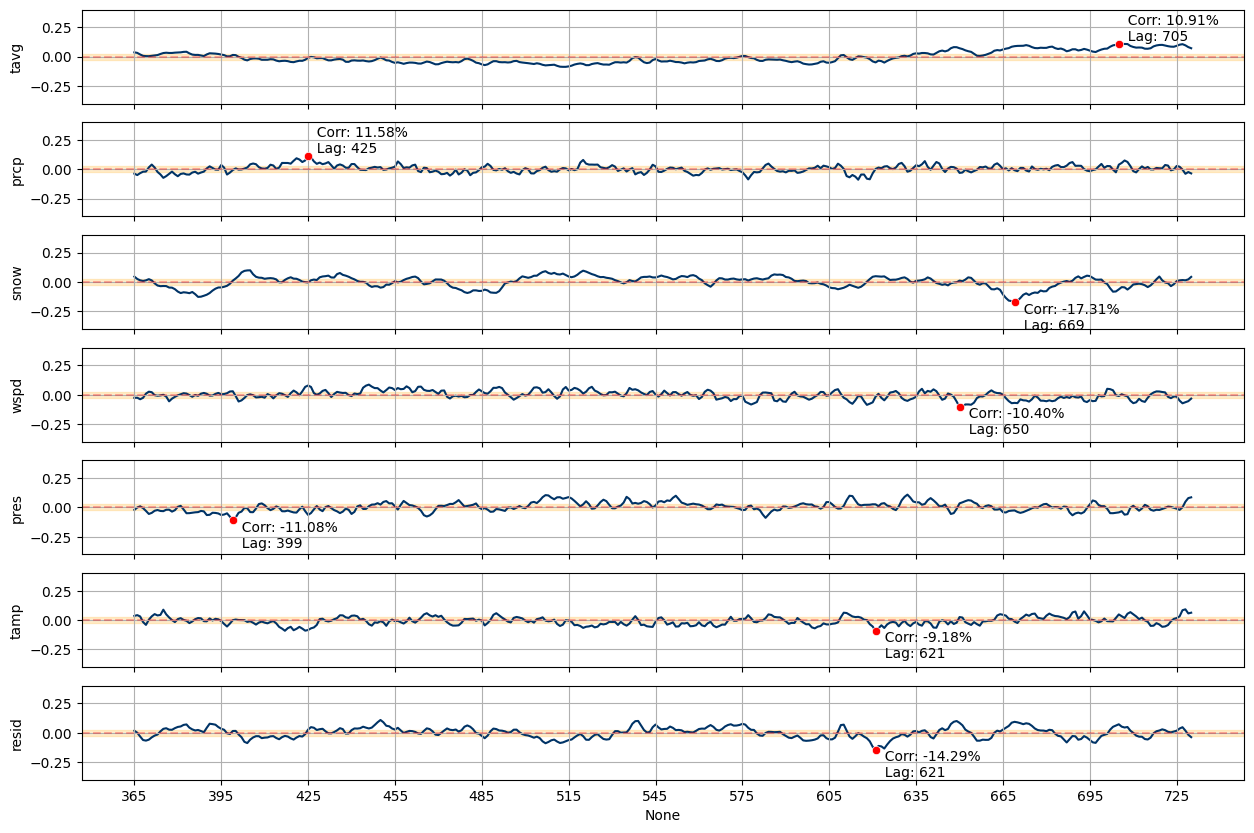

In [6]:
corr_result = pd.concat(corr_result_list).drop(columns=['shift_resid'])
threshold_corr = 0.025

fig, ax = plt.subplots(corr_result.shape[1], 1, figsize=(15, 10), sharex=True)

for i, col in enumerate(corr_result.columns):
    # Create the correlation plot for each feature
    sns.lineplot(x=corr_result.index, y=corr_result[col], ax=ax[i], zorder=1)
    ax[i].axhspan(ymin=-threshold_corr, ymax=threshold_corr, color='orange', alpha=0.2, zorder=0)
    ax[i].axhline(0, color='r', linestyle='--', alpha=0.3)

    # Getting the highest correlation
    max_id = abs(corr_result[col]).idxmax()
    max_abs_value = corr_result.loc[max_id, col]
    sns.scatterplot(x=[max_id], y=[max_abs_value],
                    color='r', ax=ax[i], zorder=2)

    # Annotation
    va = 'bottom' if max_abs_value > 0 else 'top'
    ax[i].annotate('  Corr: {:.2%}\n  Lag: {}'.format(max_abs_value, max_id), xy=(max_id, max_abs_value), ha='left', va=va)
    
    ax[i].set_ylim(-0.4, 0.4)    
    ax[i].set_xticks(np.arange(0, 365, 30)) 
    ax[i].grid()
    
plt.show()

We have just generated 7×365 features. It is clear that not all of them will be useful for the model. For this type of problem, models that typically perform best, and which we will test, are tree-based models. These models can capture nonlinear and multivariate relationships, which also makes it challenging to determine the optimal feature set manually. Therefore, we will use a Random Forest model to identify the most important variables.

In [7]:
n_feature_list = []
for col in tqdm(corr_result.columns):
    for i in range(365, 731):
        shift_n_feature = weather_df[[col]].shift(int(i))
        shift_n_feature.columns = [f'{col}_{i}']
        
        n_feature_list.append(shift_n_feature)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.72it/s]


Above, we generated only the shifted features. Now we will double the number of features by also calculating their differences: $y_t = y_t - y_{t-1}$.

In [8]:
n_feature_eng = pd.concat(n_feature_list, axis=1)
n_feature_eng_diff = n_feature_eng.diff()
n_feature_eng_diff.columns = [col + '_diff' for col in n_feature_eng_diff.columns]

n_feature_eng = pd.concat([n_feature_eng, n_feature_eng_diff], axis=1)
n_feature_eng.shape

(1825, 5124)

## Categorical
One of the available features is wcardinal, a categorical variable. We will apply the same lagging approach to this feature as we did for the numerical variables.

In [9]:
c_feature_list = []
for step in range(365, 731):
    cardinal_feature = weather_df[['wcardinal']].shift(step)
    cardinal_feature.columns = [f'wcardinal_{step}']
    c_feature_list.append(cardinal_feature)
    
c_feature_eng = pd.concat(c_feature_list, axis=1)

We can also leverage the time feature to create additional categorical features, such as day of the month, month, and season. It is important to note that lagging is neither necessary nor meaningful for these features, as their values are fully determined by the forecast date.

In [10]:
c_feature_eng['day'] = c_feature_eng.index.day
c_feature_eng['month'] = weather_df.index.strftime('%b')

c_feature_eng['season'] = 'Spring'
c_feature_eng.loc[(c_feature_eng.index.month >= 6) & (c_feature_eng.index.month <= 8), 'season'] = 'Summer'
c_feature_eng.loc[(c_feature_eng.index.month >= 9) & (c_feature_eng.index.month <= 11), 'season'] = 'Autumn'
c_feature_eng.loc[(c_feature_eng.index.month == 12) & (c_feature_eng.index.month <= 2), 'season'] = 'December'

It is likely that our model cannot handle categorical features directly. While some models, such as LightGBM, can, we must create one-hot encoded (dummy) variables for the categorical features before training our Random Forest model.

In [11]:
c_feature_eng = pd.get_dummies(c_feature_eng.dropna(), columns=c_feature_eng.drop(columns='day').columns)
c_feature_eng.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2017-08-31 to 2020-08-29
Columns: 2944 entries, day to season_Summer
dtypes: bool(2943), int32(1)
memory usage: 3.1 MB


# Feature Selection

Now that all features have been created, we can proceed to feature selection and prioritization. As mentioned earlier, we will use feature importances from a Random Forest model to define the subset of features to evaluate. Starting from over 7,000 features, we will reduce this to a priority list of 750 features. The goal is to use the minimal number of features without sacrificing predictive performance.

In [12]:
feature_eng = pd.concat([n_feature_eng, c_feature_eng, weather_df[['resid']]], axis=1).dropna()
feature_eng.shape

(1094, 8069)

In [13]:
X_train = feature_eng.drop(columns=['resid']).copy()
y_train = feature_eng['resid']

The hyperparameters were selected without concern for overfitting, as the main goal is to generate estimates that are as close as possible to the true feature importance. To achieve this, we will use 500 trees and no maximum depth, ensuring that the model fully captures the impact of each feature.

In [14]:
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=25,
    n_jobs=-1,
    verbose=1 
)

rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.0min finished


,n_estimators,500
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# Conclusion
We generate a list of 750 features estimated to be the most important, allowing us to proceed to the next phase: modeling.

In [15]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
})
feature_importance = feature_importance.sort_values(by='importance', ascending=False).\
                                head(750).reset_index(drop=True)
feature_importance

,feature,importance
0,snow_387,0.020859
1,tavg_668,0.009213
2,tavg_667,0.008607
3,resid_708,0.008298
4,tavg_620,0.006422
...,...,...
745,pres_691_diff,0.000273
746,resid_720,0.000273
747,pres_433,0.000272
748,snow_482,0.000272


In [16]:
feature_importance.to_parquet(DATA_PATH_WRANGLE / 'feature_importance.parquet')
feature_eng.to_parquet(DATA_PATH_WRANGLE / 'possible_features.parquet')